# Solves the Cartpole problem using Policy Gradients in Tensorflow

written October 2016 by Sam Greydanus

inspired by gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
import gym
import tensorflow as tf

In [2]:
n_obs = 4              # dimensionality of observations
h = 128                # number of hidden layer neurons
n_actions = 2          # number of available actions

learning_rate = 1e-2
gamma = .9             # discount factor for reward
decay = 0.9            # decay rate for RMSProp gradients

In [3]:
tf_model = {}
with tf.variable_scope('layer_one',reuse=False):
    xavier_l1 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(n_obs), dtype=tf.float32)
    tf_model['W1'] = tf.get_variable("W1", [n_obs, h], initializer=xavier_l1)
with tf.variable_scope('layer_two',reuse=False):
    xavier_l2 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(h), dtype=tf.float32)
    tf_model['W2'] = tf.get_variable("W2", [h,n_actions], initializer=xavier_l2)

In [4]:
def tf_discount_rewards(tf_r): #tf_r ~ [game_steps,1]
    discount_f = lambda a, v: a*gamma + v;
    tf_r_reverse = tf.scan(discount_f, tf.reverse(tf_r,[True, False]))
    tf_discounted_r = tf.reverse(tf_r_reverse,[True, False])
    return tf_discounted_r

def tf_policy_forward(x): #x ~ [1,D]
    h = tf.matmul(x, tf_model['W1'])
    h = tf.nn.relu(h)
    logp = tf.matmul(h, tf_model['W2'])
    p = tf.nn.softmax(logp)
    return p

def plt_dynamic(x, y, ax, colors=['b']):
    for color in colors:
        ax.plot(x, y, color)
    fig.canvas.draw()

In [5]:
env = gym.make("CartPole-v0")
observation = env.reset()
xs,rs,ys = [],[],[]
running_reward = 10 # usually starts around 10 for cartpole
reward_sum = 0
episode_number = 0
total_steps = 500

[2016-10-21 10:40:52,739] Making new env: CartPole-v0


In [6]:
#placeholders
tf_x = tf.placeholder(dtype=tf.float32, shape=[None, n_obs],name="tf_x")
tf_y = tf.placeholder(dtype=tf.float32, shape=[None, n_actions],name="tf_y")
tf_epr = tf.placeholder(dtype=tf.float32, shape=[None,1], name="tf_epr")

#gradient processing (PG magic)
tf_discounted_epr = tf_discount_rewards(tf_epr)
tf_mean, tf_variance= tf.nn.moments(tf_discounted_epr, [0], shift=None, name="reward_moments")
tf_discounted_epr -= tf_mean
tf_discounted_epr /= tf.sqrt(tf_variance + 1e-6)

# initialize tf graph
tf_aprob = tf_policy_forward(tf_x)
loss = tf.nn.l2_loss(tf_y-tf_aprob)
optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=decay)
tf_grads = optimizer.compute_gradients(loss, var_list=tf.trainable_variables(), grad_loss=tf_discounted_epr)
train_op = optimizer.apply_gradients(tf_grads)

sess = tf.InteractiveSession()
tf.initialize_all_variables().run()

<IPython.core.display.Javascript object>


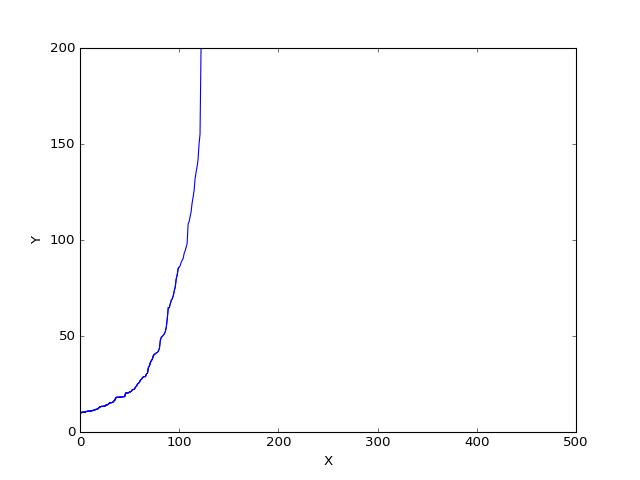

episode 0: starting up...
ep: 0, reward: 9.0, mean reward: 9.990000
ep: 25, reward: 16.0, mean reward: 13.452014
ep: 50, reward: 55.0, mean reward: 20.828585
ep: 75, reward: 101.0, mean reward: 40.474891
ep: 100, reward: 147.0, mean reward: 85.895143
ep: 124: SOLVED! (running reward hit 323.956472226 which is greater than 200)


In [ ]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('X') ; ax.set_ylabel('Y')
ax.set_xlim(0,total_steps) ; ax.set_ylim(0,200)
pxs, pys = [], []

print 'episode {}: starting up...'.format(episode_number)
while episode_number <= total_steps and running_reward < 225:
#     if episode_number%25==0: env.render()

    # stochastically sample a policy from the network
    x = observation
    feed = {tf_x: np.reshape(x, (1,-1))}
    aprob = sess.run(tf_aprob,feed) ; aprob = aprob[0,:]
    action = np.random.choice(n_actions, p=aprob)
    label = np.zeros_like(aprob) ; label[action] = 1

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward
    
    # record game history
    xs.append(x) ; ys.append(label) ; rs.append(reward)
    
    if done:
        running_reward = running_reward * 0.99 + reward_sum * 0.01
        epx = np.vstack(xs)
        epr = np.vstack(rs)
        epy = np.vstack(ys)
        xs,rs,ys = [],[],[] # reset game history
        
        feed = {tf_x: epx, tf_epr: epr, tf_y: epy}
        _ = sess.run(train_op,feed) # parameter update

        # visualization
        pxs.append(episode_number)
        pys.append(running_reward)
        if episode_number % 25 == 0:
            print 'ep: {}, reward: {}, mean reward: {:3f}'.format(episode_number, reward_sum, running_reward)
            plt_dynamic(pxs, pys, ax)
        
        # lame stuff
        episode_number += 1 # the Next Episode
        observation = env.reset() # reset env
        reward_sum = 0
        
plt_dynamic(pxs, pys, ax)
if running_reward > 225:
    print "ep: {}: SOLVED! (running reward hit {} which is greater than 200)".format(
        episode_number, running_reward)